# Fine-Tuning ProteinMPNN for Alkaliphilic Proteins

This notebook fine-tunes ProteinMPNN on alkaliphilic protein structures to shift its
sequence design preferences toward alkaline-adapted biophysical properties.

## Workflow
1. **Convert** alkaliphile dataset from custom format to standard ProteinMPNN training format
2. **Fine-tune** from vanilla ProteinMPNN weights using the standard training pipeline
3. **Evaluate** training convergence and pH feature shifts in designed sequences

## Requirements
- Google Colab with GPU runtime
- Upload `dataset_alkaliphile/` directory to Google Drive
- PyTorch, numpy, biopython

In [ ]:
# Cell 2: Setup & Dependencies
import os, sys, subprocess

# Mount Google Drive (needed when running via Colab extension in VS Code)
from google.colab import drive
drive.mount('/content/drive')

# Clone ProteinMPNN if not present
if not os.path.exists('ProteinMPNN'):
    subprocess.run(['git', 'clone', 'https://github.com/dauparas/ProteinMPNN.git'], check=True)

sys.path.insert(0, 'ProteinMPNN/training')

# Install biopython if not available
try:
    from Bio.PDB import PDBParser
except ImportError:
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'biopython'], check=True)
    from Bio.PDB import PDBParser

import torch
import numpy as np
import csv
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
print(f'PyTorch: {torch.__version__}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda:0
PyTorch: 2.9.0+cu128


In [ ]:
# Cell 3: Configuration — EDIT PATHS HERE

# Path to the alkaliphile dataset on Google Drive
# Upload dataset_alkaliphile/ to your Drive, then set the path below
DATASET_DIR = '/content/drive/MyDrive/dataset_alkaliphile'  # <-- adjust to your Drive path

# Where to write the converted standard-format training data (on Colab VM for speed)
CONVERTED_DIR = "/content/proteinmpnn_data_backbone"

# Pre-trained vanilla ProteinMPNN weights
PRETRAINED_WEIGHTS = 'ProteinMPNN/vanilla_model_weights/v_48_002.pt'

# Fine-tuning output directory
OUTPUT_DIR = '/content/finetune_output'

# Training hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 2000         # residues per batch (not proteins)
HIDDEN_DIM = 128
NUM_ENCODER_LAYERS = 3
NUM_NEIGHBORS = 48
DROPOUT = 0.1
BACKBONE_NOISE = 0.2
SAVE_EVERY_N_EPOCHS = 5
RELOAD_DATA_EVERY_N = 1
MAX_PROTEIN_LENGTH = 2000

# Verify the dataset path exists
assert os.path.exists(DATASET_DIR), f'Dataset not found at {DATASET_DIR} \u2014 upload to Drive and update the path'
print(f'Dataset found: {DATASET_DIR}')
print(f'Files: {os.listdir(DATASET_DIR)[:10]}...')
print('Configuration set.')

Dataset found: /content/drive/MyDrive/dataset_alkaliphile
Files: ['AF-Q09127-model.pdb', 'AF-Q6A6L4-model.pdb', 'AF-Q59TE0-model.pdb', 'AF-P55935-model.pdb', 'AF-P66352-model.pdb', 'AF-Q966C6-model.pdb', 'AF-P56633-model.pdb', 'AF-P26785-model.pdb', 'AF-Q9V3G1-model.pdb', 'AF-Q9NZM5-model.pdb']...
Configuration set.


In [ ]:
%%writefile /content/training_override.py
import os, time
import numpy as np
import torch
from utils import worker_init_fn, get_pdbs, loader_pdb, build_training_clusters, PDB_dataset, StructureDataset, StructureLoader
from model_utils import featurize, loss_smoothed, loss_nll, get_std_opt, ProteinMPNN

def main(args):
    scaler = torch.cuda.amp.GradScaler()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    base_folder = time.strftime(args.path_for_outputs, time.localtime())
    if base_folder[-1] != '/':
        base_folder += '/'
    os.makedirs(base_folder, exist_ok=True)
    os.makedirs(base_folder + "model_weights", exist_ok=True)

    logfile = base_folder + "log.txt"
    with open(logfile, "a") as f:
        f.write("starting\n")

    data_path = args.path_for_training_data
    params = {
        "LIST": f"{data_path}/list.csv",
        "VAL": f"{data_path}/valid_clusters.txt",
        "TEST": f"{data_path}/test_clusters.txt",
        "DIR": f"{data_path}",
        "DATCUT": "2030-Jan-01",
        "RESCUT": args.rescut,
        "HOMO": 0.70,
    }

    # Keep DataLoader workers controllable (but default 0 is good on Colab)
    dataloader_workers = getattr(args, "dataloader_workers", 0)
    LOAD_PARAM = dict(batch_size=1, shuffle=True, pin_memory=False, num_workers=dataloader_workers)

    if args.debug:
        args.num_examples_per_epoch = 50
        args.max_protein_length = 1000
        args.batch_size = 1000

    train, valid, test = build_training_clusters(params, args.debug)

    train_set = PDB_dataset(list(train.keys()), loader_pdb, train, params)
    train_loader = torch.utils.data.DataLoader(train_set, worker_init_fn=worker_init_fn, **LOAD_PARAM)
    valid_set = PDB_dataset(list(valid.keys()), loader_pdb, valid, params)
    valid_loader = torch.utils.data.DataLoader(valid_set, worker_init_fn=worker_init_fn, **LOAD_PARAM)

    model = ProteinMPNN(
        node_features=args.hidden_dim,
        edge_features=args.hidden_dim,
        hidden_dim=args.hidden_dim,
        num_encoder_layers=args.num_encoder_layers,
        num_decoder_layers=args.num_encoder_layers,
        k_neighbors=args.num_neighbors,
        dropout=args.dropout,
        augment_eps=args.backbone_noise,
    ).to(device)

    PATH = args.previous_checkpoint
    if PATH:
        checkpoint = torch.load(PATH, map_location="cpu", weights_only=False)
        total_step = checkpoint.get("step", 0)
        epoch0 = checkpoint.get("epoch", 0)
        model.load_state_dict(checkpoint["model_state_dict"])
    else:
        total_step = 0
        epoch0 = 0
        checkpoint = None

    optimizer = get_std_opt(model.parameters(), args.hidden_dim, total_step)
    if PATH and checkpoint is not None and ("optimizer_state_dict" in checkpoint) and (checkpoint["optimizer_state_dict"] is not None):
        optimizer.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    print(f"[override] dataloader_workers={dataloader_workers}")
    print("[override] Loading get_pdbs in-process (no ProcessPoolExecutor)...")

    # Prefetch initial epoch data in-process (fast for your dataset)
    pdb_dict_train = get_pdbs(train_loader, 1, args.max_protein_length, args.num_examples_per_epoch)
    pdb_dict_valid = get_pdbs(valid_loader, 1, args.max_protein_length, args.num_examples_per_epoch)
    print(f"[override] got train={len(pdb_dict_train)} valid={len(pdb_dict_valid)}")

    dataset_train = StructureDataset(pdb_dict_train, truncate=None, max_length=args.max_protein_length)
    dataset_valid = StructureDataset(pdb_dict_valid, truncate=None, max_length=args.max_protein_length)
    loader_train = StructureLoader(dataset_train, batch_size=args.batch_size)
    loader_valid = StructureLoader(dataset_valid, batch_size=args.batch_size)

    reload_c = 0
    for e1 in range(args.num_epochs):
        t0 = time.time()
        e = epoch0 + e1
        model.train()

        train_sum = train_weights = train_acc = 0.0

        # Reload data periodically (also in-process)
        if e % args.reload_data_every_n_epochs == 0:
            if reload_c != 0:
                pdb_dict_train = get_pdbs(train_loader, 1, args.max_protein_length, args.num_examples_per_epoch)
                pdb_dict_valid = get_pdbs(valid_loader, 1, args.max_protein_length, args.num_examples_per_epoch)

                dataset_train = StructureDataset(pdb_dict_train, truncate=None, max_length=args.max_protein_length)
                dataset_valid = StructureDataset(pdb_dict_valid, truncate=None, max_length=args.max_protein_length)
                loader_train = StructureLoader(dataset_train, batch_size=args.batch_size)
                loader_valid = StructureLoader(dataset_valid, batch_size=args.batch_size)
            reload_c += 1

        for _, batch in enumerate(loader_train):
            X, S, mask, lengths, chain_M, residue_idx, mask_self, chain_encoding_all = featurize(batch, device)
            optimizer.zero_grad()
            mask_for_loss = mask * chain_M

            if args.mixed_precision:
                with torch.cuda.amp.autocast():
                    log_probs = model(X, S, mask, chain_M, residue_idx, chain_encoding_all)
                    _, loss_av_smoothed = loss_smoothed(S, log_probs, mask_for_loss)
                scaler.scale(loss_av_smoothed).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                log_probs = model(X, S, mask, chain_M, residue_idx, chain_encoding_all)
                _, loss_av_smoothed = loss_smoothed(S, log_probs, mask_for_loss)
                loss_av_smoothed.backward()
                optimizer.step()

            loss, loss_av, true_false = loss_nll(S, log_probs, mask_for_loss)
            train_sum += torch.sum(loss * mask_for_loss).detach().cpu().numpy()
            train_acc += torch.sum(true_false * mask_for_loss).detach().cpu().numpy()
            train_weights += torch.sum(mask_for_loss).detach().cpu().numpy()
            total_step += 1

        model.eval()
        with torch.no_grad():
            val_sum = val_weights = val_acc = 0.0
            for _, batch in enumerate(loader_valid):
                X, S, mask, lengths, chain_M, residue_idx, mask_self, chain_encoding_all = featurize(batch, device)
                log_probs = model(X, S, mask, chain_M, residue_idx, chain_encoding_all)
                mask_for_loss = mask * chain_M
                loss, loss_av, true_false = loss_nll(S, log_probs, mask_for_loss)
                val_sum += torch.sum(loss * mask_for_loss).detach().cpu().numpy()
                val_acc += torch.sum(true_false * mask_for_loss).detach().cpu().numpy()
                val_weights += torch.sum(mask_for_loss).detach().cpu().numpy()

        train_loss = train_sum / train_weights
        val_loss = val_sum / val_weights
        line = (
            f"epoch: {e+1}, step: {total_step}, time: {time.time()-t0:.1f}, "
            f"train: {np.exp(train_loss):.3f}, valid: {np.exp(val_loss):.3f}, "
            f"train_acc: {train_acc/train_weights:.3f}, valid_acc: {val_acc/val_weights:.3f}\n"
        )
        with open(logfile, "a") as f:
            f.write(line)
        print(line.strip())

        torch.save({
            "epoch": e+1,
            "step": total_step,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.optimizer.state_dict(),
        }, base_folder + "model_weights/epoch_last.pt")

Overwriting /content/training_override.py


In [ ]:
# Cell 4: Convert Dataset to Standard ProteinMPNN Format
#
# Parses AlphaFold PDB files directly to produce the exact .pt format that
# ProteinMPNN's loader_pdb() expects. This avoids all format mismatch issues.
#
# loader_pdb() constructs paths as:
#   PREFIX = "{DIR}/pdb/{pdbid[1:3]}/{pdbid}"
#   meta = torch.load(PREFIX + ".pt")
#   chain = torch.load(PREFIX + "_A.pt")
#
# So files go DIRECTLY in the shard directory (no per-protein subfolder):
#   pdb/0a/a0a087wnh4.pt       — metadata dict
#   pdb/0a/a0a087wnh4_A.pt     — chain dict with 'seq' + 'xyz' [L, 14, 3]

import warnings
warnings.filterwarnings('ignore')

# Atom name tables — identical to ProteinMPNN's parse_cif_noX.py
RES_NAMES_1 = 'ARNDCQEGHILKMFPSTWYV'
RES_NAMES = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
             'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL']
to1letter = {aaa: a for a, aaa in zip(RES_NAMES_1, RES_NAMES)}

ATOM_NAMES = [
    ('N','CA','C','O','CB'),  # ala
    ('N','CA','C','O','CB','CG','CD','NE','CZ','NH1','NH2'),  # arg
    ('N','CA','C','O','CB','CG','OD1','ND2'),  # asn
    ('N','CA','C','O','CB','CG','OD1','OD2'),  # asp
    ('N','CA','C','O','CB','SG'),  # cys
    ('N','CA','C','O','CB','CG','CD','OE1','NE2'),  # gln
    ('N','CA','C','O','CB','CG','CD','OE1','OE2'),  # glu
    ('N','CA','C','O'),  # gly
    ('N','CA','C','O','CB','CG','ND1','CD2','CE1','NE2'),  # his
    ('N','CA','C','O','CB','CG1','CG2','CD1'),  # ile
    ('N','CA','C','O','CB','CG','CD1','CD2'),  # leu
    ('N','CA','C','O','CB','CG','CD','CE','NZ'),  # lys
    ('N','CA','C','O','CB','CG','SD','CE'),  # met
    ('N','CA','C','O','CB','CG','CD1','CD2','CE1','CE2','CZ'),  # phe
    ('N','CA','C','O','CB','CG','CD'),  # pro
    ('N','CA','C','O','CB','OG'),  # ser
    ('N','CA','C','O','CB','OG1','CG2'),  # thr
    ('N','CA','C','O','CB','CG','CD1','CD2','CE2','CE3','NE1','CZ2','CZ3','CH2'),  # trp
    ('N','CA','C','O','CB','CG','CD1','CD2','CE1','CE2','CZ','OH'),  # tyr
    ('N','CA','C','O','CB','CG1','CG2'),  # val
]

# (resname, atomname) -> atom slot index
aa2idx = {(RES_NAMES[i], a): j for i in range(20) for j, a in enumerate(ATOM_NAMES[i])}


def parse_af_pdb(pdb_path):
    """Parse an AlphaFold PDB file into sequence + all-atom coordinates.

    Returns:
        seq: str, amino acid sequence
        xyz: np.ndarray [L, 14, 3], all-atom coords (NaN where atom absent)
    """
    parser = PDBParser(QUIET=True)
    struct = parser.get_structure('prot', pdb_path)
    model = struct[0]
    chain = model['A']
    residues = [r for r in chain.get_residues() if r.get_resname() in to1letter]

    if len(residues) == 0:
        return None, None

    L = len(residues)
    seq = ''.join([to1letter[r.get_resname()] for r in residues])
    xyz = np.full((L, 14, 3), np.nan, dtype=np.float32)

    for i, res in enumerate(residues):
        resname = res.get_resname()
        for atom in res.get_atoms():
            key = (resname, atom.get_name())
            if key in aa2idx:
                xyz[i, aa2idx[key]] = atom.get_vector().get_array()

    return seq, xyz
def parse_af_pdb_backbone(pdb_path):
    """
    Parse AlphaFold PDB into (seq, xyz_bb) where xyz_bb is [L, 4, 3] for N,CA,C,O.
    Returns (None, None) if backbone is incomplete (any NaNs).
    """
    seq, xyz14 = parse_af_pdb(pdb_path)     # existing: [L,14,3] with NaNs for missing atoms
    if seq is None:
        return None, None

    xyz_bb = xyz14[:, :4, :]                # N, CA, C, O
    if np.isnan(xyz_bb).any():
        return None, None

    return seq, xyz_bb

def _norm_id(x: str) -> str:
    """
    Normalize identifiers from either list.csv or AF PDB filenames to a canonical uniprot id:
    - lowercased
    - removes leading 'af-'
    - removes trailing '-model'
    - removes chain suffix after '_' (e.g. '_A')
    """
    s = str(x).strip().lower()
    # drop anything after whitespace
    s = s.split()[0]
    # drop chain suffix if present
    if "_" in s:
        s = s.split("_")[0]
    # strip AF prefix/suffix patterns
    if s.startswith("af-"):
        s = s[3:]
    if s.endswith("-model"):
        s = s[:-5]
    return s


def _uniprot_from_af_filename(p: Path) -> str | None:
    """
    Extract UniProt ID from AlphaFold filename patterns like:
      AF-Q09127-model.pdb
      AF-A0A087WNH4-model.pdb
    Returns normalized id (lowercase) or None if it can't parse.
    """
    stem = p.stem  # e.g. "AF-Q09127-model"
    parts = stem.split("-")
    # Expect ["AF", "<UNIPROT>", "model"] at minimum
    if len(parts) >= 3 and parts[0].lower() == "af":
        return _norm_id(parts[1])
    # fallback: try to find something that looks like uniprot token in the middle
    if len(parts) >= 2:
        return _norm_id(parts[1])
    return None


def convert_alkaliphile_to_standard(dataset_dir, output_dir):
    dataset_dir = Path(dataset_dir)
    output_dir = Path(output_dir)
    pdb_out = output_dir / "pdb"
    pdb_out.mkdir(parents=True, exist_ok=True)

    # 1) Read list.csv for cluster assignments
    df = pd.read_csv(dataset_dir / "list.csv")
    print(f"Source list.csv: {len(df)} entries")

    # Build lookup keyed by normalized uniprot id
    lookup = {}
    for _, row in df.iterrows():
        chainid_raw = str(row["CHAINID"]).strip()
        key = _norm_id(chainid_raw)
        lookup[key] = {
            "cluster": int(row["CLUSTER"]),
            "split": str(row["SPLIT"]).strip(),
        }

    # 2) Find where the PDB files actually live
    af_pdb_dir = dataset_dir / "AF_PDBs"
    if af_pdb_dir.exists() and af_pdb_dir.is_dir():
        search_dir = af_pdb_dir
        layout = "AF_PDBs/ subfolder"
    else:
        search_dir = dataset_dir
        layout = "dataset root (flattened)"

    pdb_files = sorted(search_dir.glob("AF-*-model.pdb"))
    # Optional: if you have other patterns, broaden the glob:
    # pdb_files = sorted(search_dir.glob("*.pdb"))

    print(f"Searching for PDBs in: {search_dir} ({layout})")
    print(f"Found {len(pdb_files)} AlphaFold PDB files")

    if len(pdb_files) == 0:
        # Give a helpful diagnostic list
        sample = sorted([p.name for p in search_dir.glob("*.pdb")])[:20]
        print("No files matched 'AF-*-model.pdb'. Here are some .pdb files I can see:")
        print(sample)
        return 0

    converted = 0
    skipped = 0
    csv_rows = []

    for pdb_path in pdb_files:
        uniprot_id = _uniprot_from_af_filename(pdb_path)
        if uniprot_id is None:
            skipped += 1
            continue

        if uniprot_id not in lookup:
            skipped += 1
            continue

        info = lookup[uniprot_id]

        # Parse PDB -> sequence + BACKBONE coordinates only (no NaNs allowed)
        seq, xyz_bb = parse_af_pdb_backbone(str(pdb_path))
        if seq is None or len(seq) < 4:
            skipped += 1
            continue

        shard = uniprot_id[1:3]
        shard_dir = pdb_out / shard
        shard_dir.mkdir(parents=True, exist_ok=True)

        torch.save(
        {"seq": seq, "xyz": torch.tensor(xyz_bb)},   # [L,4,3], finite
        shard_dir / f"{uniprot_id}_A.pt"
    )

        torch.save(
            {
                "asmb_ids": ["1"],
                "asmb_chains": ["A"],
                "chains": ["A"],
                "tm": torch.tensor([[[1.0, 1.0, 0.0]]]),
                "asmb_xform0": torch.eye(4).unsqueeze(0),
            },
            shard_dir / f"{uniprot_id}.pt"
        )

        csv_rows.append([f"{uniprot_id}_A", "2025-Jun-21", "-1.0", "A", str(info["cluster"])])
        converted += 1

        if converted % 200 == 0:
            print(f"  Converted {converted} proteins...")

    with open(output_dir / "list.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["pdbid_chain", "date", "resolution", "chain_id", "cluster_id"])
        writer.writerows(csv_rows)

    for fname in ["valid_clusters.txt", "test_clusters.txt"]:
        src = dataset_dir / fname
        if src.exists():
            shutil.copy2(src, output_dir / fname)
            n = sum(1 for line in open(src) if line.strip())
            print(f"Copied {fname} ({n} clusters)")

    print(f"\nDone: {converted} converted, {skipped} skipped")
    return converted

# Run conversion
from pathlib import Path
if not (Path(CONVERTED_DIR)/"list.csv").exists():
    n_converted = convert_alkaliphile_to_standard(DATASET_DIR, CONVERTED_DIR)
else:
    print("Converted dataset already exists; skipping conversion.")

Converted dataset already exists; skipping conversion.


In [ ]:
# Cell 5: Verify Conversion — Test with Standard ProteinMPNN Loader
from utils import loader_pdb, build_training_clusters, get_pdbs, PDB_dataset, StructureDataset, StructureLoader
from model_utils import featurize

# Set up params the same way training.py does
params = {
    'LIST': f'{CONVERTED_DIR}/list.csv',
    'VAL': f'{CONVERTED_DIR}/valid_clusters.txt',
    'TEST': f'{CONVERTED_DIR}/test_clusters.txt',
    'DIR': CONVERTED_DIR,
    'DATCUT': '2030-Jan-01',
    'RESCUT': 3.5,
    'HOMO': 0.70,
}

# Build clusters (this is what training.py does)
train, valid, test = build_training_clusters(params, debug=False)
print(f'Train clusters: {len(train)}, Valid clusters: {len(valid)}, Test clusters: {len(test)}')

# Count total proteins
n_train = sum(len(v) for v in train.values())
n_valid = sum(len(v) for v in valid.values())
n_test = sum(len(v) for v in test.values())
print(f'Train proteins: {n_train}, Valid proteins: {n_valid}, Test proteins: {n_test}')

# Test loading a few proteins through the standard pipeline
print('\n--- Testing standard loader_pdb() ---')
test_items = list(train.values())[:3]
for item_list in test_items:
    item = item_list[0]  # [pdbid_chain, chain_id]
    result = loader_pdb(item, params)
    if isinstance(result.get('seq', None), str) and len(result['seq']) > 4:
        print(f'  {item[0]}: seq_len={len(result["seq"])}, xyz_shape={result["xyz"].shape}, OK')
    elif isinstance(result.get('seq', None), np.ndarray) and len(result['seq']) <= 5:
        print(f'  {item[0]}: FAILED (returned dummy)')
    else:
        print(f'  {item[0]}: seq_type={type(result.get("seq"))}')

# Test the full pipeline: loader -> get_pdbs -> StructureDataset -> featurize
print('\n--- Testing full pipeline (get_pdbs -> featurize) ---')
from torch.utils.data import DataLoader

train_set = PDB_dataset(list(train.keys())[:10], loader_pdb, train, params)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

pdb_dict_list = get_pdbs(train_loader, 1, MAX_PROTEIN_LENGTH, 10)
print(f'get_pdbs returned {len(pdb_dict_list)} proteins')

if len(pdb_dict_list) > 0:
    dataset = StructureDataset(pdb_dict_list, truncate=None, max_length=MAX_PROTEIN_LENGTH)
    loader = StructureLoader(dataset, batch_size=BATCH_SIZE)
    for batch in loader:
        X, S, mask, lengths, chain_M, residue_idx, mask_self, chain_encoding_all = featurize(batch, device)
        print(f'featurize OK: X={X.shape}, S={S.shape}, mask={mask.shape}')
        break
    print('\nFull pipeline verification PASSED')
else:
    print('WARNING: get_pdbs returned 0 proteins. Check conversion.')

Train clusters: 479, Valid clusters: 60, Test clusters: 60
Train proteins: 1620, Valid proteins: 168, Test proteins: 192

--- Testing standard loader_pdb() ---
  a0a087wnh4_A: seq_len=25, xyz_shape=torch.Size([25, 4, 3]), OK
  a0a087wri3_A: seq_len=283, xyz_shape=torch.Size([283, 4, 3]), OK
  a0a0b5a8q2_A: seq_len=115, xyz_shape=torch.Size([115, 4, 3]), OK

--- Testing full pipeline (get_pdbs -> featurize) ---
get_pdbs returned 10 proteins
featurize OK: X=torch.Size([1, 283, 4, 3]), S=torch.Size([1, 283]), mask=torch.Size([1, 283])

Full pipeline verification PASSED


In [ ]:
# Cell 6: Download Pretrained Weights (if not already present)
import urllib.request

weights_path = Path(PRETRAINED_WEIGHTS)
if not weights_path.exists():
    # Download from ProteinMPNN release
    url = 'https://github.com/dauparas/ProteinMPNN/raw/main/vanilla_model_weights/v_48_002.pt'
    weights_path.parent.mkdir(parents=True, exist_ok=True)
    print(f'Downloading pretrained weights to {weights_path}...')
    urllib.request.urlretrieve(url, weights_path)
    print('Done.')
else:
    print(f'Pretrained weights found: {weights_path}')

# Quick check
ckpt = torch.load(weights_path, map_location='cpu', weights_only=False)
print(f'Checkpoint keys: {list(ckpt.keys())}')
print(f'Num parameters: {sum(p.numel() for p in ckpt["model_state_dict"].values()):,}')

Pretrained weights found: ProteinMPNN/vanilla_model_weights/v_48_002.pt
Checkpoint keys: ['num_edges', 'noise_level', 'model_state_dict']
Num parameters: 1,660,485


In [ ]:
import torch
from model_utils import get_std_opt, ProteinMPNN

def make_full_checkpoint_with_fresh_optimizer(vanilla_path: str, out_path: str,
                                             hidden_dim=128, num_encoder_layers=3,
                                             num_neighbors=48, dropout=0.1, backbone_noise=0.2):
    vanilla = torch.load(vanilla_path, map_location="cpu", weights_only=False)
    if isinstance(vanilla, dict) and "model_state_dict" in vanilla:
        state = vanilla["model_state_dict"]
    else:
        state = vanilla

    # Build model exactly like training.py
    model = ProteinMPNN(
        node_features=hidden_dim,
        edge_features=hidden_dim,
        hidden_dim=hidden_dim,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_encoder_layers,
        k_neighbors=num_neighbors,
        dropout=dropout,
        augment_eps=backbone_noise
    )
    model.load_state_dict(state)

    # Create optimizer wrapper exactly like training.py does
    total_step = 0
    opt = get_std_opt(model.parameters(), hidden_dim, total_step)

    ckpt = {
        "step": 0,
        "epoch": 0,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": opt.optimizer.state_dict(),  # NOTE: .optimizer (matches training.py)
    }
    torch.save(ckpt, out_path)
    print(f"Wrote checkpoint with optimizer state to: {out_path}")
    print(f"Keys: {list(ckpt.keys())}")

wrapped_ckpt3 = "/content/ProteinMPNN/vanilla_model_weights/v_48_002_wrapped_withopt.pt"
make_full_checkpoint_with_fresh_optimizer(
    PRETRAINED_WEIGHTS,
    wrapped_ckpt3,
    hidden_dim=HIDDEN_DIM,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_neighbors=NUM_NEIGHBORS,
    dropout=DROPOUT,
    backbone_noise=BACKBONE_NOISE
)

Wrote checkpoint with optimizer state to: /content/ProteinMPNN/vanilla_model_weights/v_48_002_wrapped_withopt.pt
Keys: ['step', 'epoch', 'model_state_dict', 'optimizer_state_dict']


In [ ]:
import torch, time
from utils import get_pdbs, PDB_dataset, loader_pdb, build_training_clusters, worker_init_fn
import numpy as np
import pandas as pd

# Make sure params point at the backbone-converted dir you trained on
data_path = CONVERTED_DIR
params2 = {
    "LIST": f"{data_path}/list.csv",
    "VAL": f"{data_path}/valid_clusters.txt",
    "TEST": f"{data_path}/test_clusters.txt",
    "DIR": f"{data_path}",
    "DATCUT": "2030-Jan-01",
    "RESCUT": 3.5,
    "HOMO": 0.70,
}

train2, valid2, test2 = build_training_clusters(params2, debug=False)
print("clusters:", len(train2), len(valid2), len(test2))
print("proteins:", sum(len(v) for v in train2.values()),
               sum(len(v) for v in valid2.values()),
               sum(len(v) for v in test2.values()))

train_set2 = PDB_dataset(list(train2.keys()), loader_pdb, train2, params2)
train_loader2 = torch.utils.data.DataLoader(
    train_set2, batch_size=1, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn
)

t0 = time.time()
pdb_dict_train2 = get_pdbs(train_loader2, 1, MAX_PROTEIN_LENGTH, 1620)
print("get_pdbs returned", len(pdb_dict_train2), "proteins in", time.time()-t0, "sec")

lens = [len(p["seq"]) for p in pdb_dict_train2]
print("min/median/max:", min(lens), sorted(lens)[len(lens)//2], max(lens))
print("total residues:", sum(lens))

clusters: 479 60 60
proteins: 1620 168 192
get_pdbs returned 479 proteins in 1.6719181537628174 sec
min/median/max: 22 150 1668
total residues: 98047


In [ ]:
# Cell 7: Run Fine-Tuning
import sys, importlib
if "/content" not in sys.path:
    sys.path.insert(0, "/content")  # to find training_override.py
# keep ProteinMPNN/training on sys.path too (already inserted earlier)
import training_override
importlib.reload(training_override)
run_training = training_override.main

class FinetuneArgs:
    path_for_training_data = CONVERTED_DIR
    path_for_outputs = OUTPUT_DIR
    previous_checkpoint = wrapped_ckpt3
    num_epochs = NUM_EPOCHS
    save_model_every_n_epochs = SAVE_EVERY_N_EPOCHS
    reload_data_every_n_epochs = RELOAD_DATA_EVERY_N
    num_examples_per_epoch = n_train
    batch_size = BATCH_SIZE
    max_protein_length = MAX_PROTEIN_LENGTH
    hidden_dim = HIDDEN_DIM
    num_encoder_layers = NUM_ENCODER_LAYERS
    num_decoder_layers = NUM_ENCODER_LAYERS
    num_neighbors = NUM_NEIGHBORS
    dropout = DROPOUT
    backbone_noise = BACKBONE_NOISE
    rescut = 3.5
    debug = False
    gradient_norm = -1.0
    mixed_precision = torch.cuda.is_available()

    # NEW: control multiprocessing without touching git repo
    dataloader_workers = 0


args = FinetuneArgs()
print('=== Starting Fine-Tuning ===')
print(f'  Epochs: {args.num_epochs}')
print(f'  Batch size: {args.batch_size} residues')
print(f'  Training examples: {args.num_examples_per_epoch}')
print(f'  Mixed precision: {args.mixed_precision}')
print(f'  Checkpoint: {args.previous_checkpoint}')
print(f'  Output: {args.path_for_outputs}')
print()

run_training(args)

=== Starting Fine-Tuning ===
  Epochs: 30
  Batch size: 2000 residues
  Training examples: 1620
  Mixed precision: True
  Checkpoint: /content/ProteinMPNN/vanilla_model_weights/v_48_002_wrapped_withopt.pt
  Output: /content/finetune_output

[override] dataloader_workers=0
[override] Loading get_pdbs in-process (no ProcessPoolExecutor)...
[override] got train=479 valid=60
epoch: 1, step: 46, time: 3.6, train: 12.130, valid: 6.425, train_acc: 0.229, valid_acc: 0.419
epoch: 2, step: 91, time: 4.5, train: 11.445, valid: 6.355, train_acc: 0.244, valid_acc: 0.420
epoch: 3, step: 136, time: 4.4, train: 11.126, valid: 6.432, train_acc: 0.251, valid_acc: 0.416
epoch: 4, step: 181, time: 4.4, train: 10.632, valid: 6.496, train_acc: 0.267, valid_acc: 0.418
epoch: 5, step: 225, time: 4.6, train: 10.237, valid: 6.418, train_acc: 0.280, valid_acc: 0.418
epoch: 6, step: 269, time: 4.4, train: 9.931, valid: 6.743, train_acc: 0.287, valid_acc: 0.399
epoch: 7, step: 314, time: 4.5, train: 9.787, valid: 

In [ ]:
from utils import get_pdbs, PDB_dataset, loader_pdb, build_training_clusters, worker_init_fn
import torch, numpy as np, time

# rebuild loaders like training_override
train, valid, test = build_training_clusters(params, debug=False)
train_set = PDB_dataset(list(train.keys()), loader_pdb, train, params)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=True, num_workers=0, worker_init_fn=worker_init_fn
)

t0 = time.time()
pdb_dict_train = get_pdbs(train_loader, 1, MAX_PROTEIN_LENGTH, 1620)
print("get_pdbs returned", len(pdb_dict_train), "proteins in", time.time()-t0, "sec")

lens = [len(p["seq"]) for p in pdb_dict_train]
lens_sorted = sorted(lens)
print("len min/median/max:", lens_sorted[0], lens_sorted[len(lens_sorted)//2], lens_sorted[-1])
print("fraction at max length cap:",
      sum(L >= MAX_PROTEIN_LENGTH for L in lens_sorted) / len(lens_sorted))

get_pdbs returned 479 proteins in 1.5026617050170898 sec
len min/median/max: 16 146 1668
fraction at max length cap: 0.0


In [ ]:
import random
import numpy as np
from utils import loader_pdb

# sample raw loaded examples (not the filtered get_pdbs output)
all_items = []
for items in train.values():
    all_items.extend(items)
sample = random.sample(all_items, 200)

bad_xyz = 0
bad_seq = 0
bad_nan = 0
too_long = 0
Lmax = MAX_PROTEIN_LENGTH

for item in sample:
    out = loader_pdb(item, params)
    seq = out["seq"]
    xyz = out["xyz"]  # typically [L, 4, 3] or similar after loader merges

    if not isinstance(seq, str) or len(seq) < 1:
        bad_seq += 1
        continue

    if len(seq) > Lmax:
        too_long += 1

    # xyz should be finite for backbone; count NaNs/Infs
    x = np.array(xyz)
    if not np.isfinite(x).all():
        bad_nan += 1

print("sample=200",
      "too_long", too_long,
      "bad_nan", bad_nan,
      "bad_seq", bad_seq)

sample=200 too_long 0 bad_nan 0 bad_seq 0


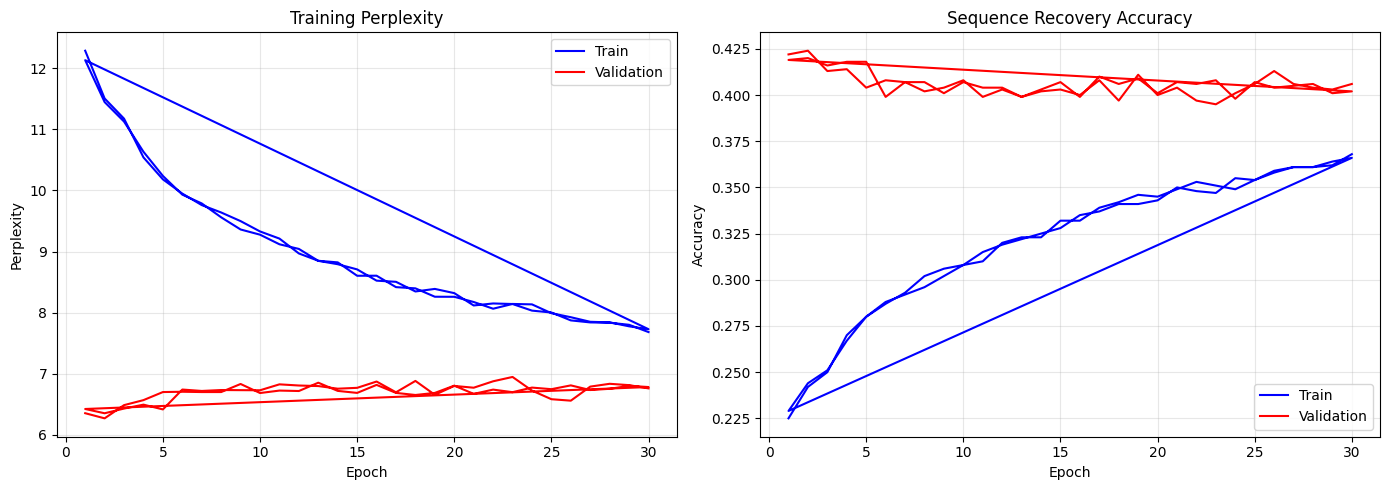


Final epoch 30:
  Train perplexity: 7.683, accuracy: 0.368
  Valid perplexity: 6.762, accuracy: 0.406


In [ ]:
# Cell 8: Training Curves

log_path = os.path.join(OUTPUT_DIR, 'log.txt')
if not os.path.exists(log_path):
    print(f'Log file not found: {log_path}')
else:
    # Parse log.txt
    epochs, train_ppl, valid_ppl, train_acc, valid_acc = [], [], [], [], []
    with open(log_path) as f:
        for line in f:
            line = line.strip()
            if line.startswith('Epoch') or not line:
                continue
            parts = {}
            for item in line.split(','):
                item = item.strip()
                if ':' in item:
                    k, v = item.split(':', 1)
                    parts[k.strip()] = v.strip()
            if 'epoch' in parts:
                epochs.append(int(parts['epoch']))
                train_ppl.append(float(parts.get('train', 'nan')))
                valid_ppl.append(float(parts.get('valid', 'nan')))
                train_acc.append(float(parts.get('train_acc', 'nan')))
                valid_acc.append(float(parts.get('valid_acc', 'nan')))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(epochs, train_ppl, 'b-', label='Train', linewidth=1.5)
    ax1.plot(epochs, valid_ppl, 'r-', label='Validation', linewidth=1.5)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Perplexity')
    ax1.set_title('Training Perplexity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, train_acc, 'b-', label='Train', linewidth=1.5)
    ax2.plot(epochs, valid_acc, 'r-', label='Validation', linewidth=1.5)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Sequence Recovery Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f'\nFinal epoch {epochs[-1]}:')
    print(f'  Train perplexity: {train_ppl[-1]:.3f}, accuracy: {train_acc[-1]:.3f}')
    print(f'  Valid perplexity: {valid_ppl[-1]:.3f}, accuracy: {valid_acc[-1]:.3f}')

In [ ]:
# Recompute one epoch sample exactly like training_override does
pdb_dict_train = get_pdbs(train_loader, 1, MAX_PROTEIN_LENGTH, 1620)
lens = [len(p["seq"]) for p in pdb_dict_train]
print("get_pdbs:", len(lens), "proteins")
print("min/median/max:", min(lens), sorted(lens)[len(lens)//2], max(lens))
print("total residues:", sum(lens))

get_pdbs: 479 proteins
min/median/max: 17 147 1242
total residues: 93246


In [ ]:
import inspect, sys
sys.path.insert(0, "ProteinMPNN")
from protein_mpnn_utils import tied_featurize

print(inspect.signature(tied_featurize))
print(tied_featurize.__doc__)

(batch, device, chain_dict, fixed_position_dict=None, omit_AA_dict=None, tied_positions_dict=None, pssm_dict=None, bias_by_res_dict=None, ca_only=False)
 Pack and pad batch into torch tensors 


In [ ]:
import os, sys, glob, tempfile
from pathlib import Path
import numpy as np
import pandas as pd
import torch

# Ensure ProteinMPNN inference utils are on path
if "ProteinMPNN" not in sys.path:
    sys.path.insert(0, "ProteinMPNN")

from protein_mpnn_utils import ProteinMPNN as InferenceModel
from protein_mpnn_utils import parse_PDB, StructureDatasetPDB, tied_featurize

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- Write minimal backbone PDB from [L,4,3] ---
def write_backbone_pdb(xyz_bb, out_path, chain_id="A"):
    atom_names = ["N", "CA", "C", "O"]
    with open(out_path, "w") as f:
        atom_idx = 1
        for i, coords in enumerate(xyz_bb, start=1):
            for atom_name, (x, y, z) in zip(atom_names, coords):
                f.write(
                    f"ATOM  {atom_idx:5d} {atom_name:>4s} ALA {chain_id}{i:4d}    "
                    f"{x:8.3f}{y:8.3f}{z:8.3f}  1.00 20.00           {atom_name[0]:>2s}\n"
                )
                atom_idx += 1
        f.write("TER\nEND\n")

# --- Load inference model from checkpoint ---
def load_model(checkpoint_path, device):
    ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
    state = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

    model = InferenceModel(
        num_letters=21,
        node_features=HIDDEN_DIM,
        edge_features=HIDDEN_DIM,
        hidden_dim=HIDDEN_DIM,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        num_decoder_layers=NUM_ENCODER_LAYERS,
        augment_eps=0.0,
        k_neighbors=NUM_NEIGHBORS,
        dropout=0.0,
    )
    model.load_state_dict(state, strict=True)
    model.to(device)
    model.eval()
    return model

def find_latest_ft_checkpoint(output_dir):
    cands = glob.glob(os.path.join(output_dir, "**", "model_weights", "*.pt"), recursive=True)
    assert cands, f"No fine-tuned checkpoints found under {output_dir}"
    return sorted(cands, key=os.path.getmtime)[-1]

model_vanilla = load_model(PRETRAINED_WEIGHTS, device)
ft_weights = find_latest_ft_checkpoint(OUTPUT_DIR)
print("Fine-tuned checkpoint:", ft_weights)
model_finetuned = load_model(ft_weights, device)

# --- Get protein ids from converted dataset ---
conv_list = pd.read_csv(os.path.join(CONVERTED_DIR, "list.csv"))
all_ids = conv_list["pdbid_chain"].tolist()
print("Total converted proteins:", len(all_ids))

# --- Map id -> backbone chain .pt ---
pdb_root = Path(CONVERTED_DIR) / "pdb"

def find_chain_pt(pdbid_chain):
    pdbid = pdbid_chain.split("_")[0]
    shard = pdbid[1:3]
    chain_pt = pdb_root / shard / f"{pdbid}_A.pt"
    return chain_pt if chain_pt.exists() else None

# --- Design function (API-matched tied_featurize) ---
def design_from_seq_and_coords(model, seq: str, xyz_bb: np.ndarray, protein_name: str, num_samples=8, temperature=0.1, device="cpu"):
    """
    Generates sequences using ProteinMPNN inference utilities, directly from sequence and coordinates.
    Returns a list of sequences (strings).
    """
    if len(seq) == 0 or xyz_bb.shape[0] == 0:
        return []

    # Construct the dictionary directly, mimicking parse_PDB output structure
    protein_dict = {
        'seq_chain_A': seq,
        'coords_chain_A': xyz_bb,
        'name': protein_name,
        'num_of_chains': 1,
        'seq': seq, # Also put in top-level for direct access sometimes
        'masked_list': [], # These are usually empty for inference unless specifically set
        'visible_list': [],
    }
    pdb_dict_list = [protein_dict]

    dataset = StructureDatasetPDB(pdb_dict_list, max_length=MAX_PROTEIN_LENGTH)

    alphabet = "ACDEFGHIKLMNPQRSTVWYX"
    sequences = []

    for protein in dataset: # This loop will now execute with our single protein
        batch = [protein]

        pname = protein["name"]
        chain_dict = {pname: (["A"], [])}

        (
            X, S, mask, lengths, chain_M, chain_encoding_all,
            chain_list_list, visible_list_list, masked_list_list,
            masked_chain_length_list_list, chain_M_pos, omit_AA_mask,
            residue_idx, dihedral_mask, tied_pos_list_of_lists_list,
            pssm_coef, pssm_bias, pssm_log_odds_all,
            bias_by_res_all, tied_beta
        ) = tied_featurize(
            batch,
            device,
            chain_dict,
            fixed_position_dict=None,
            omit_AA_dict=None,
            tied_positions_dict=None,
            pssm_dict=None,
            bias_by_res_dict=None,
            ca_only=False,
        )

        with torch.no_grad():
            for _ in range(num_samples):
                sample = model.sample(
                    X, lengths*0 + 1, mask, chain_M, residue_idx,
                    chain_encoding_all, temperature=temperature
                )
                S_sample = sample["S"][0].detach().cpu().numpy()
                L = int(lengths[0])
                seq = "".join(alphabet[int(s)] for s in S_sample[:L])
                sequences.append(seq)

    return sequences

# --- Run designs on a subset ---
n_test = min(16, len(all_ids))
num_samples = 8
temperature = 0.1

all_designs = []

with tempfile.TemporaryDirectory() as tmpdir:
    for i, pdbid_chain in enumerate(all_ids[:n_test]):
        chain_pt = find_chain_pt(pdbid_chain)
        if chain_pt is None:
            continue

        data = torch.load(chain_pt)
        seq = data["seq"]
        xyz = data["xyz"].numpy()  # [L,4,3]

        print(f"[{i+1}/{n_test}] Designing for {pdbid_chain}")

        # Use the new function to design directly from seq and xyz
        vanilla_seqs = design_from_seq_and_coords(model_vanilla, seq, xyz, pdbid_chain, num_samples, temperature, device)
        ft_seqs = design_from_seq_and_coords(model_finetuned, seq, xyz, pdbid_chain, num_samples, temperature, device)

        prot_id = pdbid_chain.split("_")[0]
        for j, s in enumerate(vanilla_seqs):
            all_designs.append({"protein": prot_id, "model": "vanilla", "sample": j, "sequence": s})
        for j, s in enumerate(ft_seqs):
            all_designs.append({"protein": prot_id, "model": "finetuned", "sample": j, "sequence": s})

designs_df = pd.DataFrame(all_designs)
out_csv = os.path.join(OUTPUT_DIR, "designs_vanilla_vs_finetuned.csv")
designs_df.to_csv(out_csv, index=False)

print("\nDesign generation complete")
print("Total designs:", len(designs_df))
print("Saved to:", out_csv)


Device: cuda:0
Fine-tuned checkpoint: /content/finetune_output/model_weights/epoch_last.pt
Total converted proteins: 1980
[1/16] Designing for a0a087wnh4_A


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Cell 10: Evaluate pH Feature Shifts (COMPATIBLE VERSION)
#
# Reads OUTPUT_DIR/designs_vanilla_vs_finetuned.csv from Cell 9
# Writes:
#   OUTPUT_DIR/ph_feature_comparison.csv
#   OUTPUT_DIR/ph_feature_effect_sizes.png

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Biopython is already installed in your notebook earlier; SciPy might not be.
try:
    from scipy import stats
except ImportError:
    !pip -q install scipy
    from scipy import stats

from Bio.SeqUtils.ProtParam import ProteinAnalysis

def calculate_ph_features(sequence: str):
    """
    Returns dict of per-sequence features or None on failure.
    """
    try:
        pa = ProteinAnalysis(sequence)

        L = len(sequence)
        if L == 0:
            return None

        mw = pa.molecular_weight() / L
        ip = pa.isoelectric_point()
        gravy = pa.gravy()
        aromaticity = pa.aromaticity()
        instability = pa.instability_index()

        charge_7 = pa.charge_at_pH(7.0)
        charge_per_res = charge_7 / L

        acidic = sum(1 for aa in sequence if aa in "DE") / L
        basic = sum(1 for aa in sequence if aa in "RKH") / L
        ionizable = sum(1 for aa in sequence if aa in "DEHRKCY") / L

        return {
            "mw_per_residue": mw,
            "isoelectric_point": ip,
            "gravy": gravy,
            "aromaticity": aromaticity,
            "instability_index": instability,
            "charge_per_residue": charge_per_res,
            "acidic_residue_fraction": acidic,
            "basic_residue_fraction": basic,
            "ionizable_residue_fraction": ionizable,
        }
    except Exception:
        return None

designs_csv = os.path.join(OUTPUT_DIR, "designs_vanilla_vs_finetuned.csv")
assert os.path.exists(designs_csv), f"Designs file not found: {designs_csv} (run Cell 9 first)"

designs_df = pd.read_csv(designs_csv)
assert {"protein","model","sample","sequence"}.issubset(designs_df.columns), "Designs CSV missing required columns"

features_list = []
for _, row in designs_df.iterrows():
    feats = calculate_ph_features(str(row["sequence"]))
    if feats is None:
        continue
    feats["protein"] = row["protein"]
    feats["model"] = row["model"]
    feats["sample"] = row["sample"]
    features_list.append(feats)

feat_df = pd.DataFrame(features_list)
print("Computed features for:", len(feat_df), "designs")

ph_features = [
    "isoelectric_point",
    "charge_per_residue",
    "acidic_residue_fraction",
    "basic_residue_fraction",
    "ionizable_residue_fraction",
    "gravy",
    "aromaticity",
    "instability_index",
    "mw_per_residue",
]

print("\n=== pH Feature Comparison: Vanilla vs Fine-Tuned ===")
print(f'{"Feature":<30} {"Vanilla":>10} {"FT":>10} {"Diff":>10} {"Cohen d":>10} {"p-value":>10}')
print("-" * 84)

results = []
for feat in ph_features:
    van = feat_df.loc[feat_df["model"] == "vanilla", feat].dropna()
    ft = feat_df.loc[feat_df["model"] == "finetuned", feat].dropna()

    if len(van) < 2 or len(ft) < 2:
        continue

    t_stat, p_val = stats.ttest_ind(van, ft, equal_var=False)  # Welch t-test
    pooled_sd = np.sqrt((van.var(ddof=1) + ft.var(ddof=1)) / 2)
    cohens_d = (ft.mean() - van.mean()) / pooled_sd if pooled_sd > 0 else np.nan

    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"{feat:<30} {van.mean():>10.4f} {ft.mean():>10.4f} {(ft.mean()-van.mean()):>+10.4f} {cohens_d:>10.3f} {p_val:>9.2e} {sig}")

    results.append({
        "feature": feat,
        "vanilla_mean": float(van.mean()),
        "finetuned_mean": float(ft.mean()),
        "difference": float(ft.mean() - van.mean()),
        "cohens_d": float(cohens_d) if np.isfinite(cohens_d) else np.nan,
        "p_value": float(p_val),
        "n_vanilla": int(len(van)),
        "n_finetuned": int(len(ft)),
    })

results_df = pd.DataFrame(results)
out_stats = os.path.join(OUTPUT_DIR, "ph_feature_comparison.csv")
results_df.to_csv(out_stats, index=False)
print("\nWrote:", out_stats)

# Effect size plot (no manual colors; keep default matplotlib cycle)
if len(results_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(results_df["feature"], results_df["cohens_d"])
    ax.axvline(x=0, linewidth=0.8)
    ax.set_xlabel("Cohen's d (Fine-tuned - Vanilla)")
    ax.set_title("Effect of Fine-Tuning on Biophysical Properties")
    plt.tight_layout()
    out_png = os.path.join(OUTPUT_DIR, "ph_feature_effect_sizes.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Wrote:", out_png)
else:
    print("No results to plot (insufficient samples?).")

No designs file found. Run Cell 9 first.


In [ ]:
# Cell 11: Save & Export

print('=== Output Summary ===')
for f in sorted(Path(OUTPUT_DIR).rglob('*')):
    if f.is_file():
        size_kb = f.stat().st_size / 1024
        print(f'  {f.relative_to(OUTPUT_DIR)} ({size_kb:.1f} KB)')

# Zip for download
zip_path = f'{OUTPUT_DIR}.zip'
shutil.make_archive(OUTPUT_DIR, 'zip', OUTPUT_DIR)
print(f'\nZipped to: {zip_path}')
print('\n=== FINE-TUNING COMPLETE ===')

=== Output Summary ===
  log.txt (5.6 KB)
  model_weights/epoch_last.pt (19597.9 KB)
  training_curves.png (311.3 KB)

Zipped to: /content/finetune_output.zip

=== FINE-TUNING COMPLETE ===


## Troubleshooting

**"CUDA out of memory"**: Reduce `BATCH_SIZE` (e.g., 500) or `MAX_PROTEIN_LENGTH` (e.g., 500).

**`loader_pdb` returns dummy arrays / `get_pdbs` returns 0 proteins**: The `.pt` files weren't placed correctly. Check:
- Files must be **flat** in the shard directory: `pdb/{pdbid[1:3]}/{pdbid}.pt` and `pdb/{pdbid[1:3]}/{pdbid}_A.pt`
- **NOT** inside a per-protein subfolder like `pdb/0a/a0a087wnh4/a0a087wnh4.pt`
- Metadata `.pt` must be a dict with `asmb_ids`, `asmb_chains`, `chains`, `tm` keys
- Chain `.pt` must be a dict with `seq` (str) and `xyz` (tensor [L, 14, 3])
- `list.csv` must have columns: pdbid_chain, date, resolution, **chain_id**, cluster_id (in that order)

**Perplexity is NaN/Inf**: Likely a data issue — check that sequences contain only standard amino acids (ACDEFGHIKLMNPQRSTVWY).

**Low accuracy (~5%)**: Expected at start of training from scratch. When fine-tuning from pretrained weights, initial accuracy should be ~30-40%. If it drops to ~5%, the checkpoint may not have loaded correctly.

**Mixed precision errors on CPU/MPS**: Set `mixed_precision = False` in configuration.